In [1]:
from huggingface_hub import hf_hub_download
from omegaconf import OmegaConf
import hydra
from src.models.complex_ins_target_extraction_module import ConditionInsExtractionComplex
import torch

# initialize the model
# change the params if needed, e.g., sampler, noise scheduler, etc.

ckpt_path = hf_hub_download(repo_id="YutongCooper/GuideSep-v1", filename="last.ckpt")
config_path = "configs/experiment/diffunet_complex_target_ins_extraction.yaml"
config = OmegaConf.load(config_path)
model_config = OmegaConf.to_container(config.model, resolve=True)

net = hydra.utils.instantiate(config.model.net, _recursive_=True)
diffusion = hydra.utils.instantiate(config.model.diffusion, _recursive_=True)
noise_distribution = hydra.utils.instantiate(config.model.noise_distribution, _recursive_=True)
sampler = hydra.utils.instantiate(config.model.sampler, _recursive_=True)
noise_scheduler = hydra.utils.instantiate(config.model.noise_scheduler, _recursive_=True)

# If model_config is not a dict but contains a _target_ key and other parameters
if "_target_" in model_config:
    # Remove the _target_ key as it's not a model parameter
    model_params = {k: v for k, v in model_config.items() if k != "_target_"}
else:
    model_params = model_config
    
model_params['net'] = net
model_params['diffusion'] = diffusion
model_params['noise_distribution'] = noise_distribution
model_params['sampler'] = sampler
model_params['noise_scheduler'] = noise_scheduler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConditionInsExtractionComplex.load_from_checkpoint(ckpt_path, 
                                                           map_location=device,
                                                           scheduler=None,  # Dummy scheduler since not needed for inference
                                                           ema_beta=0.999,  # Dummy EMA beta value
                                                           ema_power=0.75,  # Dummy EMA power value 
                                                           **model_params)

model.eval()

ConditionInsExtractionComplex(
  (net): UNet2dBase(
    (init_conv): CrossEmbedLayer(
      (convs): ModuleList(
        (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(2, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (2): Conv2d(2, 32, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
      )
    )
    (init_conv_cond): CrossEmbedLayer(
      (convs): ModuleList(
        (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(5, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (2): Conv2d(5, 32, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
      )
    )
    (to_time_hiddens): Sequential(
      (0): LearnedSinusoidalPosEmb()
      (1): Linear(in_features=17, out_features=512, bias=True)
      (2): SiLU()
    )
    (to_time_cond): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
    )
    (to_time_tokens): Sequential(
      (0): Linear(in_featu

In [2]:
# load audio samples
import torchaudio
from torchaudio.transforms import Resample
from src.data.audio_processing_utils import wav_to_mel
import numpy as np
from scipy.ndimage import gaussian_filter

def mel_spec_mask(mel_spec, threshold=0.12, filter_sig=4):
    mask = (mel_spec > threshold).astype(np.float32)
    sigma = filter_sig
    mask = gaussian_filter(mask, sigma=sigma)
    return torch.tensor(mask, dtype=torch.float32)

mixture_path = "mix/real_3_mix.wav"  # Replace with your mixture audio file path
condition_path = "cond/real_3_humming.wav"  # Replace with your condition audio file path
mixture, sr_mix = torchaudio.load(mixture_path)
condition, sr_cond = torchaudio.load(condition_path)
# Resample if necessary
if sr_mix != 16000:
    resampler = Resample(orig_freq=sr_mix, new_freq=16000)
    mixture = resampler(mixture)
if sr_cond != 16000:
    resampler = Resample(orig_freq=sr_cond, new_freq=16000)
    condition = resampler(condition)
    
if mixture.shape[0] > 1:  # If stereo, convert to mono
    mixture = mixture.mean(dim=0, keepdim=True)
if condition.shape[0] > 1:  # If stereo, convert to mono
    condition = condition.mean(dim=0, keepdim=True)

if mixture.shape[1] != condition.shape[1]:
    min_length = min(mixture.shape[1], condition.shape[1])
    mixture = mixture[:, :min_length]
    condition = condition[:, :min_length]
    
mixture = mixture / torch.max(torch.abs(mixture))
condition = condition / torch.max(torch.abs(condition))

# mel spectrogram parameters
mel_filterbank = torchaudio.transforms.MelScale(n_mels=80, sample_rate=16000, n_stft=256)
window = torch.hann_window(510, periodic=True)
stft_args = dict(n_fft=510, hop_length=256, center=True)

# optional pseudo-masking, change the threshold and filter_sig if needed
# pseudo-masking negative mask
mixture_mel = wav_to_mel(wav=mixture,
                window=window,
                stft_args=stft_args,
                mel_filterbank=mel_filterbank)
mixture_mel_mask = mel_spec_mask(mel_spec=mixture_mel.numpy(),
                                          threshold=0.1,
                                          filter_sig=3)
mixture_mel_mask = mixture_mel_mask / torch.max(mixture_mel_mask + 1e-10)

# pseudo-masking positive mask
condition_mel = wav_to_mel(wav=condition,
                window=window,
                stft_args=stft_args,
                mel_filterbank=mel_filterbank)
condition_mel_mask = mel_spec_mask(mel_spec=condition_mel.numpy(),
                                          threshold=0.1,
                                          filter_sig=3)
condition_mel_mask = condition_mel_mask / torch.max(condition_mel_mask + 1e-10)
    
print(f"Mixture shape: {mixture.shape}, Condition shape: {condition.shape}")

Mixture shape: torch.Size([1, 172009]), Condition shape: torch.Size([1, 172009])


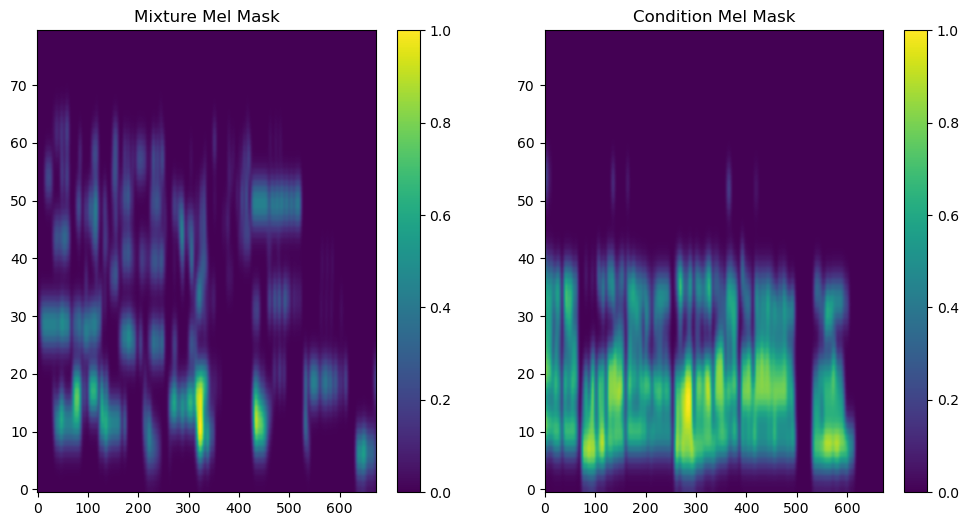

In [3]:
# play the audio
import IPython.display as ipd
ipd.display(ipd.Audio(mixture.numpy(), rate=16000))
ipd.display(ipd.Audio(condition.numpy(), rate=16000))

# display the mel masks
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(mixture_mel_mask.squeeze(0).numpy(), aspect='auto', origin='lower')
plt.title('Mixture Mel Mask')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(condition_mel_mask.squeeze(0).numpy(), aspect='auto', origin='lower')
plt.title('Condition Mel Mask')
plt.colorbar()
plt.show()

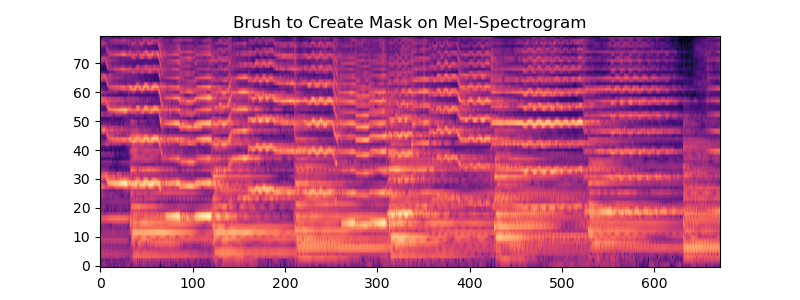

In [4]:
# optional: draw a mask yourself
%matplotlib widget

import librosa
import matplotlib.pyplot as plt
from ipywidgets import Button, FloatSlider, IntSlider, ToggleButton, VBox, Text, HBox
from IPython.display import display

S = mixture_mel.clone()
S = S.squeeze().numpy()
S_dB = librosa.power_to_db(S, ref=np.max)

# Initialize mask
mask = np.zeros_like(S_dB)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 3))
ax.imshow(S_dB, aspect='auto', origin='lower', cmap='magma')
plt.title('Brush to Create Mask on Mel-Spectrogram')

# Brush properties
brush_size = 8  # Default brush size
mask_value = 1.0  # Default mask value
eraser_mode = False  # Default mode is drawing

# Function to handle mouse motion
def on_motion(event):
    if event.inaxes is not None and event.button == 1:  # Check if left mouse button is pressed
        x, y = int(event.xdata), int(event.ydata)
        # Update the mask within the brush area
        for i in range(y - brush_size, y + brush_size + 1):
            for j in range(x - brush_size, x + brush_size + 1):
                if 0 <= i < S_dB.shape[0] and 0 <= j < S_dB.shape[1]:
                    if eraser_mode:
                        mask[i, j] = 0  # Erase (set mask value to 0)
                    else:
                        mask[i, j] = mask_value  # Draw (set mask value)
        # Update the plot
        if hasattr(on_motion, 'mask_image'):
            on_motion.mask_image.remove()
        on_motion.mask_image = ax.imshow(mask, cmap='Reds', alpha=0.4, origin='lower')  # Overlay mask
        fig.canvas.draw()

# Connect the motion event to the function
fig.canvas.mpl_connect('motion_notify_event', on_motion)

# Function to save the mask
# change the path to save the mask as needed
def save_mask(b):
    np.save('mask_real_1_mix_p.npy', mask)

# Function to update brush size
def update_brush_size(change):
    global brush_size
    brush_size = change.new

# Function to update mask value
def update_mask_value(change):
    global mask_value
    mask_value = change.new

# Function to toggle eraser mode
def toggle_eraser(change):
    global eraser_mode
    eraser_mode = change.new
    eraser_button.description = "Eraser: ON" if eraser_mode else "Eraser: OFF"

# Function to load a mask from the server
def load_mask(b):
    global mask
    mask_path = mask_path_text.value  # Get the path from the text input
    try:
        mask = np.load(mask_path)  # Load the mask from the server
        # Update the plot
        if hasattr(on_motion, 'mask_image'):
            on_motion.mask_image.remove()
        on_motion.mask_image = ax.imshow(mask, cmap='Reds', alpha=0.4, origin='lower')  # Overlay mask
        fig.canvas.draw()
        print(f"Mask loaded successfully from {mask_path}!")
    except Exception as e:
        print(f"Error loading mask: {e}")

# Create sliders for brush size and mask value
brush_size_slider = IntSlider(value=8, min=1, max=20, step=1, description='Brush Size:')
mask_value_slider = FloatSlider(value=1.0, min=0.0, max=1.0, step=0.1, description='Mask Value:')

# Create a toggle button for eraser mode
eraser_button = ToggleButton(value=False, description='Eraser: OFF')
eraser_button.observe(toggle_eraser, names='value')

# Create a text input for the mask path
mask_path_text = Text(placeholder='Enter path to mask file (e.g., masks/mask.npy)', description='Mask Path:')

# Create a button to load the mask
load_mask_button = Button(description="Load Mask")
load_mask_button.on_click(load_mask)

# Create a save button
save_button = Button(description="Save Mask")
save_button.on_click(save_mask)

# Attach slider updates to their respective functions
brush_size_slider.observe(update_brush_size, names='value')
mask_value_slider.observe(update_mask_value, names='value')

# Display sliders, eraser button, load mask input, and save button
display(VBox([
    brush_size_slider,
    mask_value_slider,
    eraser_button,
    HBox([mask_path_text, load_mask_button]),  # Text input and load button in a horizontal layout
    save_button
]))

plt.show()

In [4]:
def drop_mel_mask(p_drop_prob, n_drop_prob, batch_size, device):
    _p_mask = torch.rand(batch_size)
    _n_mask = torch.rand(batch_size)
    p_mask = (_p_mask < p_drop_prob)
    n_mask = (_n_mask < n_drop_prob)

    p_mask = p_mask.view(-1, 1, 1, 1).contiguous().to(device)
    n_mask = n_mask.view(-1, 1, 1, 1).contiguous().to(device)
    
    return p_mask, n_mask

# optional: load a mask
# p_mask_path = "mask_real_1_mix_p.npy"  # Replace with your positive mask path
# n_mask_path = "mask_real_1_mix_n.npy"  # Replace with your negative mask path
# mel_p_mask = torch.tensor(np.load(p_mask_path)).unsqueeze(0).to(device)
# mel_n_mask = torch.tensor(np.load(n_mask_path)).unsqueeze(0).to(device)

# optional: set pseudo-mel masks
mel_p_mask = condition_mel_mask.to(device)
mel_n_mask = mixture_mel_mask.to(device)

# optional drop mel masks 
p_mask, n_mask = drop_mel_mask(p_drop_prob=1,
                                n_drop_prob=1,
                                batch_size=mixture.shape[0],
                                device=device)

# optional: set condition to None, i.e. only input the mask 
# condition = None
condition = condition.to(device)

# if using mask, simply set the p_mask and n_mask to None
# p_mask = None
# n_mask = None

# print((p_mask))



In [5]:
# inference
with torch.no_grad():
    audio_sample, _ = model.inference(condition=(condition, mel_p_mask, mel_n_mask), 
                                      mixture=mixture.to(device), 
                                        diff_net=model.net,
                                        p_mask=p_mask,
                                        n_mask=n_mask)

# play the audio
ipd.display(ipd.Audio(audio_sample.cpu().numpy(), rate=16000))